<img src = "https://thumbs2.imgbox.com/32/93/xRH3CBEG_t.png" width="250">

# Calculando a Probabilidade de Inadimplência
---

In [1]:
# importanto bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
import scikitplot.plotters as skplt
from mlxtend.plotting import plot_confusion_matrix
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

from funcoes.funcoes import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# importando dados
dados_WoE_VI   = pd.read_csv('dados/dados_WoE_VI_final.csv')
dados_LightGBM = pd.read_csv('dados/dados_LightGBM_final.csv')

In [3]:
dados_WoE_VI.shape

(877648, 79)

In [4]:
dados_LightGBM.shape

(877648, 73)

## Classificação e métricas avaliativas

Após passar pelo entendimento de negócio, compreensão dos dados e preparação dos dados, o próximo passo é a modelagem e avaliação. O modelo preditivo que vamos criar é a Regressão Logística e a avaliação se dá por meio da análise das principais métricas, como segue:

- **Acurácia:** a proporção de casos que foram corretamente previstos, sejam eles verdadeiro positivo ou verdadeiro negativo.

- **Precisão:** é o número de resultados verdadeiros positivos dividido pelo número de resultados positivos previstos pelo classificador.

- **Recall:** dentre todas as situações de classe positivo como valor esperado, quantas estão corretas.

- **F1-score:** é a média harmônica da precisão e recall, onde um F1-score atinge seu melhor valor em 1 (precisão e recall perfeitos) e pior em 0. É uma boa maneira de mostrar que um classificador tem um bom valor tanto para o recall quanto para a precisão. 

- **Matriz de Confusão:** mostra uma tabela, ferramenta que resumi o desempenho de um algoritmo de classificação, com uma visão clara do desempenho do modelo de classificação e os tipos de erros produzidos pelo modelo. Será apresentado um resumo das previsões corretas e incorretas discriminadas por cada categoria.

- **ROC-AUC:** Receiver Operating Characteristics (ROC) e Area Under the Curve (AUC) são duas métricas muito utilizadas para modelos de classificação. Neste caso, quanto maior a AUC, melhor a distinção entre clientes bons e maus.
---


### Balanceamento das classes

Como dito anteriormente, as classes encontram-se desbalanceadas, nestes casos, este procedimento é necessário, caso contrário o modelo ficará enviesado, ou seja, irá saber distinguir e prever muito bem os dados da classe majoritária, mas terá dificuldades para fazer o mesmo com a classe minoritária.

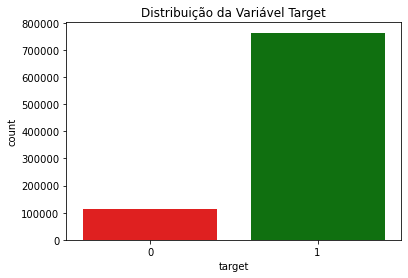

In [5]:
plt.title('Distribuição da Variável Target')
sns.countplot(x = dados_WoE_VI.target , palette = ['red', 'green']);

## Criando modelo com features selecionadas por WoE e IV
---

Primeiramente o conjunto de dados será balanceado utilizando o SMOTE e depois será aplicada a regressão logística nos dados selecionados.

In [6]:
# separando dados
X = dados_WoE_VI.drop(['target', 'funded_amnt', 'total_rec_prncp', 'loan_status', 'recoveries'], axis = 1).values
y = dados_WoE_VI[['target']].values

In [7]:
# tratando o desbalanceamento das classes da variável target
smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X, y)

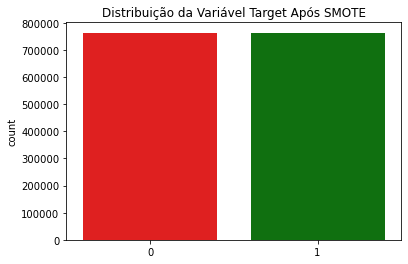

In [8]:
plt.title('Distribuição da Variável Target Após SMOTE')
sns.countplot(x = y_smote , palette = ['red', 'green']);

In [9]:
# separando dados de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state = 42)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1068943, 77)
(458119, 77)
(1068943,)
(458119,)


###  Regressão Logística

A regressão logística é um algoritmo de classificação de aprendizado supervisionado usado para prever observações para um conjunto discreto de classes, ou seja, classifica as observações em diferentes categorias com uma saída discreta por natureza. A regressão logística também é chamada de regressão logit. É um dos algoritmos de classificação mais simples, diretos e versáteis que é usado para resolver problemas de classificação e será aplicado a seguir no conjunto de dados.

In [11]:
# instanciando modelo
logregpd = LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 42, penalty = 'l2')

# fit do modelo
logregpd.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [12]:
y_pred_test = logregpd.predict(X_test)
y_pred_test

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [13]:
print('Acurácia de teste: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

Acurácia de teste: 0.7867


In [14]:
y_pred_train = logregpd.predict(X_train)
y_pred_train

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

In [15]:
print('Acurácia de treino: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Acurácia de treino: 0.7850


Comparação da precisão do conjunto de treino e do conjunto de teste para verificar se há overfitting. Como os valores são próximos, não há overfiting (uma grande diferença nos dois valores pode indicar overfitting ou underfitting). 

In [16]:
print('Score de treino: {:.4f}'.format(logregpd.score(X_train, y_train)))
print('Score de teste: {:.4f}'.format(logregpd.score(X_test, y_test)))

Score de treino: 0.7850
Score de teste: 0.7867


O método predict_proba fornece as probabilidades da target (0 e 1) neste caso, em forma de array

In [17]:
# bons = 1
y_test_pred = logregpd.predict_proba(X_test)[:, 1] 
y_test_pred

array([0.13699627, 0.39873102, 0.93519097, ..., 0.72186058, 0.49049607,
       0.68630887])

In [18]:
# ruins = 0
y_test_pred = logregpd.predict_proba(X_test)[:, 0] 
y_test_pred

array([0.86300373, 0.60126898, 0.06480903, ..., 0.27813942, 0.50950393,
       0.31369113])

#### Métricas de classificação

O relatório de classificação é outra forma de avaliar o desempenho do modelo de classificação. Ele exibe precisão, recall, f1 e scores de suporte do modelo.

In [19]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79    229168
           1       0.78      0.79      0.79    228951

    accuracy                           0.79    458119
   macro avg       0.79      0.79      0.79    458119
weighted avg       0.79      0.79      0.79    458119



#### Acurácia da classificação

In [20]:
cm = confusion_matrix(y_test, y_pred_test)

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Acurácia da classificação: {0:0.4f}'.format(classification_accuracy))

Acurácia da classificação: 0.7867


#### Erro da classificação

In [21]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Erro da classificação: {0:0.4f}'.format(classification_error))

Erro da classificação: 0.2133


#### Threshold de classificação

Há um threshold de classificação de 0,5 comumente utilizado e que também será aplicado neste caso.

- Classe 1 - probabilidade de ser bom é prevista se probabilidade > 0,5
- Classe 0 - probabilidade de ser ruim é prevista se probabilidade < 0,5

O dataframe abaixo mostra a probablidade de uma pessoa apresentar risco de crédito (ruim) ou não (bom), segundo a classificação do modelo. 

In [22]:
y_pred_prob = logregpd.predict_proba(X_test)[0:15]

In [23]:
# exemplo da probabilidade das 15 primeiras classificações feitas
y_pred_prob_df = pd.DataFrame(data = y_pred_prob, columns=['Prob_Ruim(0)', 'Prob_Bom(1)'])
y_pred_prob_df

,Prob_Ruim(0),Prob_Bom(1)
0,0.863004,0.136996
1,0.601269,0.398731
2,0.064809,0.935191
3,0.102301,0.897699
4,0.062944,0.937056
5,0.360066,0.639934
6,0.836898,0.163102
7,0.119614,0.880386
8,0.011445,0.988555
9,0.143142,0.856858


#### ROC-AUC

Esta é uma técnica para comparar o desempenho do classificador onde se mede a área sob a curva (AUC). Um classificador perfeito terá um ROC AUC igual a 1, enquanto um classificador aleatório terá um ROC AUC igual a 0,5.

Portanto, ROC AUC é a porcentagem do gráfico ROC que está abaixo da curva.

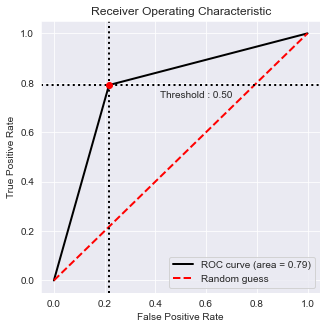

In [24]:
# plot curva ROC
bc = BinaryClassification(y_test, y_pred_test, labels = [0, 1])
plt.figure(figsize = (5, 5))
bc.plot_roc_curve()
plt.show()

#### Matriz de confusão

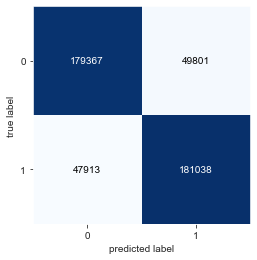

In [25]:
#cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

#### Histograma da classe 1

Foram separadas as probabilidades do evento acontecer, apenas os dados da classe 1, e pode-se ver que a distribuição é bimodal.

In [26]:
# selecionando as probabilidades previstas para a classe 1 - probabilidade de ser bom
y_pred1 = logregpd.predict_proba(X_test)[:, 1]

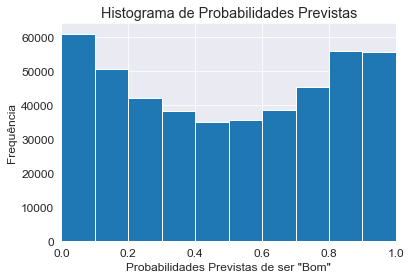

In [27]:
plt.rcParams['font.size'] = 12
plt.hist(y_pred1, bins = 10)
plt.title('Histograma de Probabilidades Previstas')
plt.xlim(0, 1)
plt.xlabel('Probabilidades Previstas de ser "Bom"')
plt.ylabel('Frequência');

#### Histograma da classe 0

Foram separadas as probabilidades do evento acontecer, apenas os dados da classe 0, e pode-se ver que a distribuição também é bimodal.

In [28]:
# selecionando as probabilidades previstas para a classe 0 - probabilidade de ser ruim
y_pred2 = logregpd.predict_proba(X_test)[:, 0]

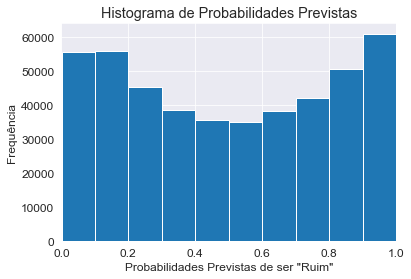

In [29]:
plt.rcParams['font.size'] = 12
plt.hist(y_pred2, bins = 10)
plt.title('Histograma de Probabilidades Previstas')
plt.xlim(0, 1)
plt.xlabel('Probabilidades Previstas de ser "Ruim"')
plt.ylabel('Frequência');

#### Gini

É um coeficiente utilizado para medir a desigualdade entre adimplentes e inadimplentes em modelos de risco de crédito.

Gini = (ROC-AUC * 2 -1)

In [30]:
Gini = 0.78 * 2 - 1
Gini

0.56

#### KS - Kolmogorov–Smirnov

KS é um coeficiente que define a máxima diferença entre as funções de distribuição cumulativa de adimplentes e inadimplentes.

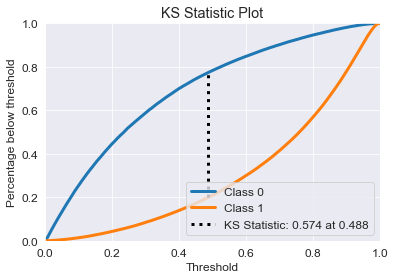

In [31]:
y_test_pred = logregpd.predict_proba(X_test)
skplt.plot_ks_statistic(y_test, y_test_pred)
plt.show()

### P-valor

Uma abordagem que pode ser utilizada para remover mais features é checar a significância estatística dos coeficientes de cada variável olhando o p-valor. Por meio de uma regressão logística multivariada o p-valor será calculado e, caso seu valor seja menor do que 0.05, ou seja, estatisticamente significante, essa variável continuará no modelo, caso contrário, será retirada.  

*(em caso de dummies, se uma das categorias apresentar significância, todas as outras podem continuar no modelo)*

In [32]:
reg2 = LogisticRegression_with_p_values()
reg2.fit(X_train, y_train)

In [35]:
nomes_features = dados_WoE_VI.drop(['target', 'funded_amnt', 'total_rec_prncp', 'loan_status', 'recoveries'], axis = 1).columns.values

In [36]:
tabela_sumario = pd.DataFrame(columns = ['nome_feature'], data = nomes_features)
tabela_sumario['coeficiente'] = np.transpose(reg2.coef_)
tabela_sumario.index = tabela_sumario.index + 1
tabela_sumario.loc[0] = ['intercept', reg2.intercept_[0]]
tabela_sumario = tabela_sumario.sort_index()

p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
tabela_sumario['p_valor'] = p_values
tabela_sumario

,nome_feature,coeficiente,p_valor
0,intercept,-10.076345,NaN
1,purpose:credit_card,2.258435,0.0
2,purpose:debt_consolidation,1.998950,0.0
3,purpose:home_improvement,2.635993,0.0
4,home_ownership:OWN,0.845471,0.0
...,...,...,...
73,total_rev_hi_lim:10000-20000,1.569981,0.0
74,total_rev_hi_lim:20000-40000,1.538325,0.0
75,total_rev_hi_lim:40000-60000,1.761187,0.0
76,total_rev_hi_lim:60000-80000,2.067609,0.0


Pela análise de significância nenhuma das variáveis deveria ser retirada.

In [37]:
tabela_sumario[tabela_sumario.p_valor < 0.05]

,nome_feature,coeficiente,p_valor
1,purpose:credit_card,2.258435,0.0
2,purpose:debt_consolidation,1.998950,0.0
3,purpose:home_improvement,2.635993,0.0
4,home_ownership:OWN,0.845471,0.0
5,verification_status:Not Verified,0.989579,0.0
...,...,...,...
73,total_rev_hi_lim:10000-20000,1.569981,0.0
74,total_rev_hi_lim:20000-40000,1.538325,0.0
75,total_rev_hi_lim:40000-60000,1.761187,0.0
76,total_rev_hi_lim:60000-80000,2.067609,0.0


### Avaliação e melhoria do modelo

Agora algumas técnicas serão empregadas para melhorar o desempenho do modelo, sendo elas: validação cruzada k-fold e otimização de hiperparâmetros usando GridSearchCV.

#### Validação cruzada k-fold

O score do modelo original é de 0.7867 e a pontuação média de validação cruzada é 0.7849. Assim, podemos concluir que a validação cruzada não resulta em melhoria de desempenho.

In [36]:
scores = cross_val_score(logregpd, X_train, y_train, cv = 5, scoring = 'accuracy')

print('Scores validação cruzada:{}'.format(scores))
print('Média scores validação cruzada: {:.4f}'.format(scores.mean()))

Scores validação cruzada:[0.78444635 0.78526959 0.78504975 0.78591408 0.7836408 ]
Média scores validação cruzada: 0.7849


#### Otimização de hiperparâmetros usando GridSearchCV

GridSearchCV é um algoritmo de busca que recebe uma conjunto de valores de um ou mais hiperparâmetros e testa todas as combinações dentro dessa vizinhança.

In [37]:
parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]

grid_search = GridSearchCV(estimator = logregpd,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0,
                           n_jobs=8)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [38]:
# examinando o melhor modelo

print('Melhor score do GridSearchCV: {:.4f}\n\n'.format(grid_search.best_score_))
print('Parâmetros que dão os melhores resultados:','\n\n', (grid_search.best_params_))
print('\n\nEstimador que foi escolhido:','\n\n', (grid_search.best_estimator_))
print('Score de teste GridSearchCV: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

Melhor score do GridSearchCV: 0.7849


Parâmetros que dão os melhores resultados: 

 {'penalty': 'l2'}


Estimador que foi escolhido: 

 LogisticRegression(max_iter=1000, random_state=42)
Score de teste GridSearchCV: 0.7867


In [38]:
# salvando modelo
import pickle
pickle.dump(logregpd, open('modelos/modelo_pd_v1.sav', 'wb'))

### Resultados

   - A acurácia do modelo de regressão logística é de 78% e a ROC-AUC que se aproxima de 1. Assim, pode-se concluir que o classificador consegue prever o risco de crédito, sem mostrar sinais de overfitting. 
    
   - f-1 score: 79%, Recall: 79%

   - Os coeficientes de KS e Gini apresentam bons resultados, 0.56, o que significa que o modelo está conseguindo separar bem as classes.

   - O score do modelo original e a pontuação média de validação cruzada são iguais, então a validação cruzada não resulta em melhoria de desempenho.

   - O GridSearchCV apresenta acurácia de 0.7867, e a acurácia de teste do modelo original 0.7867, ou seja, pode melhorar o desempenho para este modelo específico, mas não é uma melhora muito significativa.
---

## Criando modelo com features selecionadas pelo LightGBM
---

In [69]:
# separando dados
X = dados_LightGBM.drop(['target'], axis = 1).values
y = dados_LightGBM[['target']].values

In [70]:
# tratando o desbalanceamento das classes da variável target
smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X, y)

In [71]:
# separando dados de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state = 42)

In [72]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1068943, 72)
(458119, 72)
(1068943,)
(458119,)


### Regressão Logística

In [73]:
# instanciando modelo
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 42)

# fit do modelo
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [74]:
y_pred_test = logreg.predict(X_test)
y_pred_test

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [75]:
print('Acurácia de teste: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

Acurácia de teste: 0.8697


In [76]:
y_pred_train = logreg.predict(X_train)
y_pred_train

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

In [77]:
print('Acurácia de treino: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Acurácia de treino: 0.8699


Como os valores são próximos, não há overfiting.

In [78]:
print('Score de treino: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Score de teste: {:.4f}'.format(logreg.score(X_test, y_test)))

Score de treino: 0.8699
Score de teste: 0.8697


O método predict_proba fornece as probabilidades da target (0 e 1) neste caso, em forma de array

In [79]:
# bons = 1
y_test_pred = logreg.predict_proba(X_test)[:, 1] 
y_test_pred

array([0.33180457, 0.03147318, 0.98225841, ..., 0.32546591, 1.        ,
       0.99999874])

In [80]:
# ruins = 0
y_test_pred = logreg.predict_proba(X_test)[:, 0] 
y_test_pred

array([6.68195429e-01, 9.68526822e-01, 1.77415861e-02, ...,
       6.74534095e-01, 4.10531165e-09, 1.25704092e-06])

#### Métricas de classificação

In [81]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88    229168
           1       0.92      0.81      0.86    228951

    accuracy                           0.87    458119
   macro avg       0.88      0.87      0.87    458119
weighted avg       0.88      0.87      0.87    458119



#### Acurácia da classificação

In [82]:
cm = confusion_matrix(y_test, y_pred_test)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Acurácia da classificação: {0:0.4f}'.format(classification_accuracy))

Acurácia da classificação: 0.8697


#### Erro da classificação

In [83]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Erro da classificação: {0:0.4f}'.format(classification_error))

Erro da classificação: 0.1303


#### Threshold de classificação

Há um threshold de classificação de 0,5 comumente utilizado e que também será aplicado neste caso.

- Classe 1 - probabilidade de ser bom é prevista se probabilidade > 0,5
- Classe 0 - probabilidade de ser ruim é prevista se probabilidade < 0,5

In [84]:
y_pred_prob = logreg.predict_proba(X_test)[0:15]

In [85]:
# exemplo da probabilidade das 15 primeiras classificações feitas
y_pred_prob_df = pd.DataFrame(data = y_pred_prob, columns = ['Prob_Ruim(0)', 'Prob_Bom(1)'])
y_pred_prob_df

,Prob_Ruim(0),Prob_Bom(1)
0,0.668195,0.331805
1,0.968527,0.031473
2,0.017742,0.982258
3,0.242352,0.757648
4,0.346400,0.653600
5,0.012607,0.987393
6,0.520525,0.479475
7,0.949489,0.050511
8,0.000433,0.999567
9,0.800496,0.199504


#### ROC-AUC

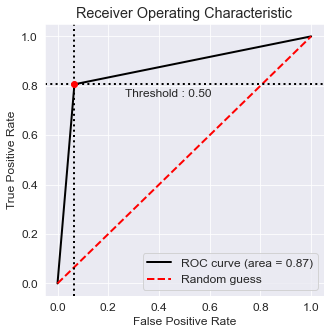

In [86]:
# plot curva ROC
bc = BinaryClassification(y_test, y_pred_test, labels = [0, 1])
plt.figure(figsize = (5, 5))
bc.plot_roc_curve()
plt.show()

#### Matriz de confusão

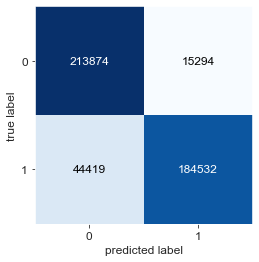

In [87]:
plot_confusion_matrix(cm)
plt.show()

#### Histograma da classe 1

Foram separadas as probabilidades do evento acontecer, apenas os dados da classe 1, e pode-se ver que o histograma é bimodal.

In [88]:
# selecionando as probabilidades previstas para a classe 1 - probabilidade de ser bom
y_pred1 = logreg.predict_proba(X_test)[:, 1]

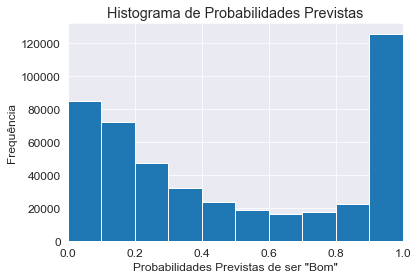

In [89]:
plt.rcParams['font.size'] = 12
plt.hist(y_pred1, bins = 10)
plt.title('Histograma de Probabilidades Previstas')
plt.xlim(0, 1)
plt.xlabel('Probabilidades Previstas de ser "Bom"')
plt.ylabel('Frequência');

#### Histograma da classe 0

Foram separadas as probabilidades do evento acontecer, apenas os dados da classe 1, e pode-se ver que o histograma é bimodal.

In [90]:
# selecionando as probabilidades previstas para a classe 0 - probabilidade de ser ruim
y_pred2 = logreg.predict_proba(X_test)[:, 0]

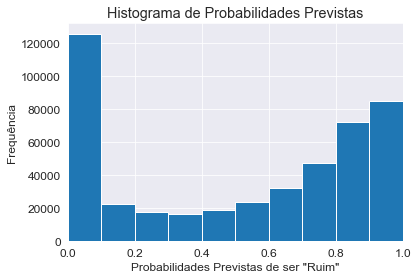

In [91]:
plt.rcParams['font.size'] = 12
plt.hist(y_pred2, bins = 10)
plt.title('Histograma de Probabilidades Previstas')
plt.xlim(0, 1)
plt.xlabel('Probabilidades Previstas de ser "Ruim"')
plt.ylabel('Frequência');

#### Gini

Gini = (ROC-AUC * 2 -1)

In [94]:
Gini = 0.87 * 2 - 1
Gini

0.74

#### KS - Kolmogorov–Smirnov

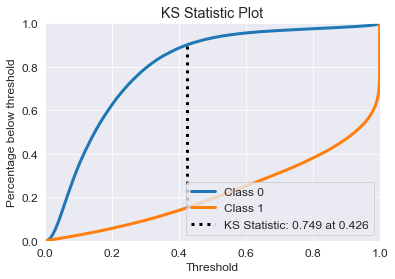

In [93]:
y_test_pred = logreg.predict_proba(X_test)
skplt.plot_ks_statistic(y_test, y_test_pred)
plt.show()

### Avaliação e melhoria do modelo

Agora algumas técnicas serão empregadas para melhorar o desempenho do modelo, sendo elas: validação cruzada k-fold e otimização de hiperparâmetros usando GridSearchCV.

#### Validação cruzada k-fold

O score do modelo original é de 0.8527 e a pontuação média de validação cruzada foi de 0.8554. Assim, podemos concluir que a validação cruzada pode resultar em melhoria de desempenho.

In [95]:
scores = cross_val_score(logreg, X_train, y_train, cv = 5, scoring = 'accuracy')

print('Scores validação cruzada:{}'.format(scores))
print('Média scores validação cruzada: {:.4f}'.format(scores.mean()))

Scores validação cruzada:[0.87042364 0.87004476 0.86947411 0.86990851 0.86923494]
Média scores validação cruzada: 0.8698


#### Otimização de hiperparâmetros usando GridSearchCV

In [98]:
parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]

grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0,
                           n_jobs=8)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=8,
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [99]:
print('Melhor score do GridSearchCV: {:.4f}\n\n'.format(grid_search.best_score_))
print('Parâmetros que dão os melhores resultados:','\n\n', (grid_search.best_params_))
print('\n\nEstimador que foi escolhido:','\n\n', (grid_search.best_estimator_))
print('Score de teste GridSearchCV: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

Melhor score do GridSearchCV: 0.8698


Parâmetros que dão os melhores resultados: 

 {'penalty': 'l2'}


Estimador que foi escolhido: 

 LogisticRegression(max_iter=1000, random_state=42)
Score de teste GridSearchCV: 0.8697


### Resultados

   - A acurácia do modelo de regressão logística é de 86% e a ROC-AUC se aproxima de 1. Assim, podemos concluir que o classificador consegue prever o risco de crédito, sem mostrar sinais de overfitting. 
    
   - f-1 score: 86%, Recall: 81% 

   - Os coeficientes de KS e Gini apresentam bons resultados, 0.74, o que significa que o modelo está conseguindo separar bem as classes.

   - A validação cruzada pode resultar em melhoria de desempenho do modelo.

   - O GridSearchCV apresenta acurácia de 0.8698, e a acurácia de teste do modelo original 0.8527, ou seja, também houve uma melhora no desempenho do modelo.

---

### Conclusão

Em projetos de data science, o ideal é testar diferentes modelos de machine learning e diferentes técnicas para manipular o conjunto de dados e otimizar o modelo, no entanto, neste estudo apenas a Regressão Logística foi aplicada para o conjunto de dados e validação cruzada e GridSearchCV para melhoria do modelo. 

Apesar dessas considerações, os modelos performaram bem, apresentaram bons resultados e são considerados suficientes para o propósito do projeto, com isso, a próxima etapa será a criação do scorecard e depois o cálculo de índice de perda por inadimplência com a regressão linear. No entanto, apenas o modelo em que as features foram selecionadas por WoE e IV será usado.

---